In [110]:
import json
import urllib2
import geopandas as gp
from shapely.geometry import Point
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline

# Read API Key

In [2]:
f = open('./api.txt', 'r')
key = f.readlines()[0]

# NYC Stations

In [3]:
nyc_cb = pd.read_csv("../../Data/NYCstations.csv", header=None)
nyc_cb.columns = ['station_id', 'lat', 'long']

boro = gp.read_file("../../Data/Boroughs/boroughs.shp")
boro.to_crs(epsg=4326, inplace=True)

In [4]:
crs = {'init': 'epsg:4326', 'no_defs': True}
geometry = [Point(xy) for xy in zip(nyc_cb["long"], nyc_cb["lat"])]
# nyc_cb = nyc_cb.drop(["long", "lat"], axis=1)
nyc_cb = gp.GeoDataFrame(nyc_cb, crs=crs, geometry=geometry)
    
#"Spatially joining cb_stations and boroughs"
nyc_cbstations = gp.sjoin(nyc_cb, boro) 
nyc_cbstations.drop(['geometry', u'index_right', 'Shape_Area', 'Shape_Leng',
                    u'OBJECTID', 'Shape_Le_1', 'BoroCode'], axis = 1, inplace = True)  
nyc_cbstations.reset_index(inplace=True, drop=True)

# Manhattan

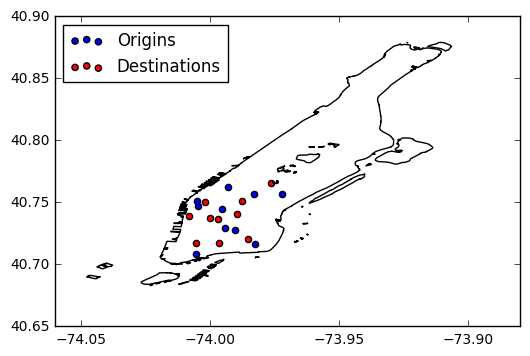

In [5]:
nyc_manhattan_org = nyc_cbstations[nyc_cbstations.BoroName == 'Manhattan'].sample(10, random_state = 100)
nyc_manhattan_org.reset_index(inplace=True, drop=True)
nyc_manhattan_des = nyc_cbstations[nyc_cbstations.BoroName == 'Manhattan'].sample(10, random_state = 200)
nyc_manhattan_des.reset_index(inplace=True, drop=True)

fig = plt.figure()
ax = fig.gca()
boro[boro.BoroName == 'Manhattan'].plot(ax = ax, alpha = 0)
plt.scatter(nyc_manhattan_org['long'],nyc_manhattan_org.lat, c = 'blue', label = 'Origins')
plt.scatter(nyc_manhattan_des['long'],nyc_manhattan_des.lat, c = 'red', label = 'Destinations')
plt.legend(loc='best')

In [6]:
def parameters(df):
    para = ''
    for i in range(len(df)):
        if i == (len(df) - 1):
            para = para + str(df.iloc[i]['lat']) + ',' + str(df.iloc[i]['long'])
        else:
            para = para + str(df.iloc[i]['lat']) + ',' + str(df.iloc[i]['long']) + '|'
    return para

In [7]:
org = parameters(nyc_manhattan_org) 
des = parameters(nyc_manhattan_des) 
t = str(int(time.mktime(time.strptime('2017-05-27 18:00:00', '%Y-%m-%d %H:%M:%S'))))

In [8]:
def create_frame(org, dest, info, mode, time):

    routes = pd.DataFrame()

    k = 0
    for i in range(len(org)):
        for j in range(len(dest)):
            routes.loc[k, 'org_id'] = org.iloc[i]['station_id']
            routes.loc[k, 'org_lat'] = org.iloc[i]['lat']
            routes.loc[k, 'org_long'] = org.iloc[i]['long']
            routes.loc[k, 'org_name'] = info['origin_addresses'][i]
        
            routes.loc[k, 'des_id'] = dest.iloc[j]['station_id']
            routes.loc[k, 'des_lat'] = dest.iloc[j]['lat']
            routes.loc[k, 'des_long'] = dest.iloc[j]['long']
            routes.loc[k, 'des_name'] = info['destination_addresses'][j]
            
            ## Bicycle
            if mode == 'bicycling':
                routes.loc[k, 'dist_bike_mi'] = float(info['rows'][i]['elements'][j]['distance']
                                                      ['text'].split(' ')[0])
                routes.loc[k, 'dur_bike_mins'] = float(info['rows'][i]['elements'][j]['duration']
                                                       ['text'].split(' ')[0])
            ## Driving at Various times
            if (mode == 'driving') & (time == '6pm'):
                routes.loc[k, 'dist_drive_6pm_mi'] = float(info['rows'][i]['elements'][j]['distance']
                                                           ['text'].split(' ')[0])
                routes.loc[k, 'dur_drive_6pm_mins'] = float(info['rows'][i]['elements'][j]
                                                            ['duration_in_traffic']['text'].split(' ')[0])
            if (mode == 'driving') & (time == '9am'):
                routes.loc[k, 'dist_drive_9am_mi'] = float(info['rows'][i]['elements'][j]['distance']
                                                           ['text'].split(' ')[0])
                routes.loc[k, 'dur_drive_9am_mins'] = float(info['rows'][i]['elements'][j]
                                                            ['duration_in_traffic']['text'].split(' ')[0])
            if (mode == 'driving') & (time == '2pm'):
                routes.loc[k, 'dist_drive_2pm_mi'] = float(info['rows'][i]['elements'][j]['distance']
                                                           ['text'].split(' ')[0])
                routes.loc[k, 'dur_drive_2pm_mins'] = float(info['rows'][i]['elements'][j]
                                                            ['duration_in_traffic']['text'].split(' ')[0])
            if (mode == 'driving') & (time == '2pm_sat'):
                routes.loc[k, 'dist_drive_2pm_sat_mi'] = float(info['rows'][i]['elements'][j]['distance']
                                                           ['text'].split(' ')[0])
                routes.loc[k, 'dur_drive_2pm_sat_mins'] = float(info['rows'][i]['elements'][j]
                                                            ['duration_in_traffic']['text'].split(' ')[0])
        
            ## Transit at Various times
            if (mode == 'transit') & (time == '6pm'):
                routes.loc[k, 'dist_transit_6pm_mi'] = float(info['rows'][i]['elements'][j]['distance']
                                                           ['text'].split(' ')[0])
                routes.loc[k, 'dur_transit_6pm_mins'] = float(info['rows'][i]['elements'][j]
                                                            ['duration']['text'].split(' ')[0])
            if (mode == 'transit') & (time == '9am'):
                routes.loc[k, 'dist_transit_9am_mi'] = float(info['rows'][i]['elements'][j]['distance']
                                                           ['text'].split(' ')[0])
                routes.loc[k, 'dur_transit_9am_mins'] = float(info['rows'][i]['elements'][j]
                                                            ['duration']['text'].split(' ')[0])
            if (mode == 'transit') & (time == '2pm'):
                routes.loc[k, 'dist_transit_2pm_mi'] = float(info['rows'][i]['elements'][j]['distance']
                                                           ['text'].split(' ')[0])
                routes.loc[k, 'dur_transit_2pm_mins'] = float(info['rows'][i]['elements'][j]
                                                            ['duration']['text'].split(' ')[0])
            if (mode == 'transit') & (time == '2pm_sat'):
                routes.loc[k, 'dist_transit_2pm_sat_mi'] = float(info['rows'][i]['elements'][j]['distance']
                                                           ['text'].split(' ')[0])
                routes.loc[k, 'dur_transit_2pm_sat_mins'] = float(info['rows'][i]['elements'][j]
                                                            ['duration']['text'].split(' ')[0])            
            

            k = k + 1    
    
    return routes

# Bicycling

In [13]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org + "&destinations=" +des + "&mode=bicycling&key="+key)

In [14]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [16]:
routes = pd.DataFrame()

k = 0
for i in range(10):
    for j in range(10):
        routes.loc[k, 'org_id'] = nyc_manhattan_org.iloc[i]['station_id']
        routes.loc[k, 'org_lat'] = nyc_manhattan_org.iloc[i]['lat']
        routes.loc[k, 'org_long'] = nyc_manhattan_org.iloc[i]['long']
        routes.loc[k, 'org_name'] = info['origin_addresses'][i]
        
        routes.loc[k, 'des_id'] = nyc_manhattan_des.iloc[j]['station_id']
        routes.loc[k, 'des_lat'] = nyc_manhattan_des.iloc[j]['lat']
        routes.loc[k, 'des_long'] = nyc_manhattan_des.iloc[j]['long']
        routes.loc[k, 'des_name'] = info['destination_addresses'][j]
        
        routes.loc[k, 'distance_mi'] = float(info['rows'][i]['elements'][j]['distance']['text'].split(' ')[0])
        routes.loc[k, 'duration_mins'] = float(info['rows'][i]['elements'][j]['duration']['text'].split(' ')[0])
        k = k + 1


In [17]:
routes_bike = routes.copy()

In [18]:
routes_bike.columns

Index([u'org_id', u'org_lat', u'org_long', u'org_name', u'des_id', u'des_lat',
       u'des_long', u'des_name', u'distance_mi', u'duration_mins'],
      dtype='object')

In [19]:
routes_bike.columns = [u'org_id', u'org_lat', u'org_long', u'org_name', u'des_id', u'des_lat',
                       u'des_long', u'des_name', u'dist_bike_mi', u'dur_bike_mins']

In [20]:
routes_bike.head(2)

,org_id,org_lat,org_long,org_name,des_id,des_lat,des_long,des_name,dist_bike_mi,dur_bike_mins
0,306.0,40.708235,-74.005301,"28 Cliff St, New York, NY 10038, USA",405.0,40.739323,-74.008119,"91 Gansevoort St, New York, NY 10014, USA",4.0,20.0
1,306.0,40.708235,-74.005301,"28 Cliff St, New York, NY 10038, USA",223.0,40.737815,-73.999947,"175 W 13th St, New York, NY 10011, USA",2.6,18.0


# Driving at 6pm

In [21]:
t = str(int(time.mktime(time.strptime('2017-05-29 18:00:00', '%Y-%m-%d %H:%M:%S'))))

In [22]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org + "&destinations=" +des + "&mode=driving&departure_time=" + t + "&key="+key)

In [23]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [24]:
routes = pd.DataFrame()

k = 0
for i in range(10):
    for j in range(10):
        routes.loc[k, 'org_id'] = nyc_manhattan_org.iloc[i]['station_id']
        routes.loc[k, 'org_lat'] = nyc_manhattan_org.iloc[i]['lat']
        routes.loc[k, 'org_long'] = nyc_manhattan_org.iloc[i]['long']
        routes.loc[k, 'org_name'] = info['origin_addresses'][i]
        
        routes.loc[k, 'des_id'] = nyc_manhattan_des.iloc[j]['station_id']
        routes.loc[k, 'des_lat'] = nyc_manhattan_des.iloc[j]['lat']
        routes.loc[k, 'des_long'] = nyc_manhattan_des.iloc[j]['long']
        routes.loc[k, 'des_name'] = info['destination_addresses'][j]
        
        routes.loc[k, 'distance_mi'] = float(info['rows'][i]['elements'][j]['distance']['text'].split(' ')[0])
        routes.loc[k, 'duration_mins'] = float(info['rows'][i]['elements'][j]['duration_in_traffic']['text'].split(' ')[0])
        k = k + 1

In [25]:
routes_drive_6pm = routes.copy()

In [26]:
routes_drive_6pm.columns

Index([u'org_id', u'org_lat', u'org_long', u'org_name', u'des_id', u'des_lat',
       u'des_long', u'des_name', u'distance_mi', u'duration_mins'],
      dtype='object')

In [27]:
routes_drive_6pm.columns = [u'org_id', u'org_lat', u'org_long', u'org_name', u'des_id', u'des_lat',
                            u'des_long', u'des_name', u'dist_drive_6pm_mi', u'dur_drive_6pm_mins']

# Driving at 9am

In [28]:
t = str(int(time.mktime(time.strptime('2017-05-29 09:00:00', '%Y-%m-%d %H:%M:%S'))))

In [29]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org + "&destinations=" +des + "&mode=driving&departure_time=" + t + "&key="+key)

In [30]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [31]:
routes = pd.DataFrame()

k = 0
for i in range(10):
    for j in range(10):
        routes.loc[k, 'org_id'] = nyc_manhattan_org.iloc[i]['station_id']
        routes.loc[k, 'org_lat'] = nyc_manhattan_org.iloc[i]['lat']
        routes.loc[k, 'org_long'] = nyc_manhattan_org.iloc[i]['long']
        routes.loc[k, 'org_name'] = info['origin_addresses'][i]
        
        routes.loc[k, 'des_id'] = nyc_manhattan_des.iloc[j]['station_id']
        routes.loc[k, 'des_lat'] = nyc_manhattan_des.iloc[j]['lat']
        routes.loc[k, 'des_long'] = nyc_manhattan_des.iloc[j]['long']
        routes.loc[k, 'des_name'] = info['destination_addresses'][j]
        
        routes.loc[k, 'distance_mi'] = float(info['rows'][i]['elements'][j]['distance']['text'].split(' ')[0])
        routes.loc[k, 'duration_mins'] = float(info['rows'][i]['elements'][j]['duration_in_traffic']['text'].split(' ')[0])
        k = k + 1

In [32]:
routes_drive_9am = routes.copy()

In [33]:
routes_drive_9am.columns = [u'org_id', u'org_lat', u'org_long', u'org_name', u'des_id', u'des_lat',
                            u'des_long', u'des_name', u'dist_drive_9am_mi', u'dur_drive_9am_mins']

# Driving at 2pm

In [34]:
t = str(int(time.mktime(time.strptime('2017-05-29 14:00:00', '%Y-%m-%d %H:%M:%S'))))

In [35]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org + "&destinations=" +des + "&mode=driving&departure_time=" + t + "&key="+key)

In [36]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [37]:
routes = pd.DataFrame()

k = 0
for i in range(10):
    for j in range(10):
        routes.loc[k, 'org_id'] = nyc_manhattan_org.iloc[i]['station_id']
        routes.loc[k, 'org_lat'] = nyc_manhattan_org.iloc[i]['lat']
        routes.loc[k, 'org_long'] = nyc_manhattan_org.iloc[i]['long']
        routes.loc[k, 'org_name'] = info['origin_addresses'][i]
        
        routes.loc[k, 'des_id'] = nyc_manhattan_des.iloc[j]['station_id']
        routes.loc[k, 'des_lat'] = nyc_manhattan_des.iloc[j]['lat']
        routes.loc[k, 'des_long'] = nyc_manhattan_des.iloc[j]['long']
        routes.loc[k, 'des_name'] = info['destination_addresses'][j]
        
        routes.loc[k, 'distance_mi'] = float(info['rows'][i]['elements'][j]['distance']['text'].split(' ')[0])
        routes.loc[k, 'duration_mins'] = float(info['rows'][i]['elements'][j]['duration_in_traffic']['text'].split(' ')[0])
        k = k + 1

In [38]:
routes_drive_2pm = routes.copy()

In [39]:
routes_drive_2pm.columns = [u'org_id', u'org_lat', u'org_long', u'org_name', u'des_id', u'des_lat',
                            u'des_long', u'des_name', u'dist_drive_2pm_mi', u'dur_drive_2pm_mins']

# Driving at 2pm on Saturday

In [55]:
t = str(int(time.mktime(time.strptime('2017-06-03 14:00:00', '%Y-%m-%d %H:%M:%S'))))

In [56]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org + "&destinations=" +des + "&mode=driving&departure_time=" + t + "&key="+key)

In [57]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [61]:
routes = pd.DataFrame()

k = 0
for i in range(10):
    for j in range(10):
        routes.loc[k, 'org_id'] = nyc_manhattan_org.iloc[i]['station_id']
        routes.loc[k, 'org_lat'] = nyc_manhattan_org.iloc[i]['lat']
        routes.loc[k, 'org_long'] = nyc_manhattan_org.iloc[i]['long']
        routes.loc[k, 'org_name'] = info['origin_addresses'][i]
        
        routes.loc[k, 'des_id'] = nyc_manhattan_des.iloc[j]['station_id']
        routes.loc[k, 'des_lat'] = nyc_manhattan_des.iloc[j]['lat']
        routes.loc[k, 'des_long'] = nyc_manhattan_des.iloc[j]['long']
        routes.loc[k, 'des_name'] = info['destination_addresses'][j]
        
        routes.loc[k, 'distance_mi'] = float(info['rows'][i]['elements'][j]['distance']['text'].split(' ')[0])
        routes.loc[k, 'duration_mins'] = float(info['rows'][i]['elements'][j]['duration_in_traffic']['text'].split(' ')[0])
        k = k + 1

In [62]:
routes_drive_2pm_sat = routes.copy()

In [63]:
routes_drive_2pm_sat.columns = [u'org_id', u'org_lat', u'org_long', u'org_name', u'des_id', u'des_lat',
                            u'des_long', u'des_name', u'dist_drive_2pm_sat_mi', u'dur_drive_2pm_sat_mins']

In [64]:
routes_drive_2pm_sat

,org_id,org_lat,org_long,org_name,des_id,des_lat,des_long,des_name,dist_drive_2pm_sat_mi,dur_drive_2pm_sat_mins
0,306.0,40.708235,-74.005301,"28 Cliff St, New York, NY 10038, USA",405.0,40.739323,-74.008119,"91 Gansevoort St, New York, NY 10014, USA",2.7,18.0
1,306.0,40.708235,-74.005301,"28 Cliff St, New York, NY 10038, USA",223.0,40.737815,-73.999947,"175 W 13th St, New York, NY 10011, USA",2.5,18.0
2,306.0,40.708235,-74.005301,"28 Cliff St, New York, NY 10038, USA",410.0,40.720664,-73.985180,"162-166 Suffolk St, New York, NY 10002, USA",2.8,11.0
3,306.0,40.708235,-74.005301,"28 Cliff St, New York, NY 10038, USA",320.0,40.717571,-74.005549,"67-69 Leonard St, New York, NY 10013, USA",1.2,11.0
4,306.0,40.708235,-74.005301,"28 Cliff St, New York, NY 10038, USA",489.0,40.750664,-74.001768,"401-499 W 28th St, New York, NY 10001, USA",3.4,19.0
5,306.0,40.708235,-74.005301,"28 Cliff St, New York, NY 10038, USA",263.0,40.717290,-73.996375,"54-58 Elizabeth St, New York, NY 10013, USA",1.1,13.0
6,306.0,40.708235,-74.005301,"28 Cliff St, New York, NY 10038, USA",2006.0,40.765909,-73.976342,"6697 Central Park S, New York, NY 10019, USA",6.2,25.0
7,306.0,40.708235,-74.005301,"28 Cliff St, New York, NY 10038, USA",402.0,40.740343,-73.989551,"931 Broadway, New York, NY 10010, USA",4.6,21.0
8,306.0,40.708235,-74.005301,"28 Cliff St, New York, NY 10038, USA",345.0,40.736494,-73.997044,"68 W 13th St, New York, NY 10011, USA",2.8,22.0
9,306.0,40.708235,-74.005301,"28 Cliff St, New York, NY 10038, USA",267.0,40.750977,-73.987654,"1332-1350 Broadway, New York, NY 10018, USA",5.2,20.0


# Transit at 6pm

In [65]:
t = str(int(time.mktime(time.strptime('2017-05-29 18:00:00', '%Y-%m-%d %H:%M:%S'))))

In [66]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org + "&destinations=" +des + "&mode=transit&departure_time=" + t + "&key="+key)

In [67]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [68]:
routes_transit_6pm = create_frame(org=nyc_manhattan_org, dest=nyc_manhattan_des, info=info, mode='transit', time='6pm')

In [69]:
routes_transit_6pm

,org_id,org_lat,org_long,org_name,des_id,des_lat,des_long,des_name,dist_transit_6pm_mi,dur_transit_6pm_mins
0,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",405.0,40.739323,-74.008119,"812 Washington St, New York, NY 10014, USA",2.9,22.0
1,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",223.0,40.737815,-73.999947,"64 7th Ave, New York, NY 10011, USA",2.4,12.0
2,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",410.0,40.720664,-73.985180,"162-166 Suffolk St, New York, NY 10002, USA",2.1,17.0
3,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",320.0,40.717571,-74.005549,"66 Leonard St, New York, NY 10013, USA",1.1,14.0
4,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",489.0,40.750664,-74.001768,"444-498 W 28th St, New York, NY 10001, USA",3.6,29.0
5,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",263.0,40.717290,-73.996375,"54 Elizabeth St, New York, NY 10013, USA",1.3,15.0
6,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",2006.0,40.765909,-73.976342,"6697 Central Park S, New York, NY 10019, USA",5.0,35.0
7,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",402.0,40.740343,-73.989551,"931 Broadway, New York, NY 10010, USA",2.9,21.0
8,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",345.0,40.736494,-73.997044,"68 W 13th St, New York, NY 10011, USA",2.7,16.0
9,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",267.0,40.750977,-73.987654,"1332-1350 Broadway, New York, NY 10018, USA",3.6,21.0


# Transit at 9am

In [70]:
t = str(int(time.mktime(time.strptime('2017-05-29 09:00:00', '%Y-%m-%d %H:%M:%S'))))

In [71]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org + "&destinations=" +des + "&mode=transit&departure_time=" + t + "&key="+key)

In [72]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [73]:
routes_transit_9am = create_frame(org=nyc_manhattan_org, dest=nyc_manhattan_des, info=info, mode='transit', time='9am')

In [74]:
routes_transit_9am

,org_id,org_lat,org_long,org_name,des_id,des_lat,des_long,des_name,dist_transit_9am_mi,dur_transit_9am_mins
0,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",405.0,40.739323,-74.008119,"812 Washington St, New York, NY 10014, USA",2.9,21.0
1,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",223.0,40.737815,-73.999947,"64 7th Ave, New York, NY 10011, USA",2.4,11.0
2,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",410.0,40.720664,-73.985180,"162-166 Suffolk St, New York, NY 10002, USA",2.1,17.0
3,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",320.0,40.717571,-74.005549,"66 Leonard St, New York, NY 10013, USA",1.1,13.0
4,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",489.0,40.750664,-74.001768,"444-498 W 28th St, New York, NY 10001, USA",4.2,29.0
5,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",263.0,40.717290,-73.996375,"54 Elizabeth St, New York, NY 10013, USA",1.3,15.0
6,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",2006.0,40.765909,-73.976342,"6697 Central Park S, New York, NY 10019, USA",5.3,31.0
7,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",402.0,40.740343,-73.989551,"931 Broadway, New York, NY 10010, USA",3.0,21.0
8,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",345.0,40.736494,-73.997044,"68 W 13th St, New York, NY 10011, USA",2.7,15.0
9,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",267.0,40.750977,-73.987654,"1332-1350 Broadway, New York, NY 10018, USA",3.6,20.0


# Transit at 2pm

In [75]:
t = str(int(time.mktime(time.strptime('2017-05-29 14:00:00', '%Y-%m-%d %H:%M:%S'))))

In [76]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org + "&destinations=" +des + "&mode=transit&departure_time=" + t + "&key="+key)

In [77]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [78]:
routes_transit_2pm = create_frame(org=nyc_manhattan_org, dest=nyc_manhattan_des, info=info, mode='transit', time='2pm')

In [79]:
routes_transit_2pm

,org_id,org_lat,org_long,org_name,des_id,des_lat,des_long,des_name,dist_transit_2pm_mi,dur_transit_2pm_mins
0,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",405.0,40.739323,-74.008119,"812 Washington St, New York, NY 10014, USA",2.9,21.0
1,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",223.0,40.737815,-73.999947,"64 7th Ave, New York, NY 10011, USA",2.4,11.0
2,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",410.0,40.720664,-73.985180,"162-166 Suffolk St, New York, NY 10002, USA",2.1,18.0
3,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",320.0,40.717571,-74.005549,"66 Leonard St, New York, NY 10013, USA",1.1,13.0
4,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",489.0,40.750664,-74.001768,"444-498 W 28th St, New York, NY 10001, USA",3.6,29.0
5,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",263.0,40.717290,-73.996375,"54 Elizabeth St, New York, NY 10013, USA",1.3,16.0
6,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",2006.0,40.765909,-73.976342,"6697 Central Park S, New York, NY 10019, USA",5.3,33.0
7,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",402.0,40.740343,-73.989551,"931 Broadway, New York, NY 10010, USA",3.0,22.0
8,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",345.0,40.736494,-73.997044,"68 W 13th St, New York, NY 10011, USA",2.7,15.0
9,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",267.0,40.750977,-73.987654,"1332-1350 Broadway, New York, NY 10018, USA",3.6,19.0


# Transit at 2pm on Saturday

In [98]:
t = str(int(time.mktime(time.strptime('2017-06-03 14:00:00', '%Y-%m-%d %H:%M:%S'))))

In [99]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org + "&destinations=" +des + "&mode=transit&departure_time=" + t + "&key="+key)

In [100]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [101]:
routes_transit_2pm_sat = create_frame(org=nyc_manhattan_org, dest=nyc_manhattan_des, info=info, mode='transit', time='2pm_sat')

In [102]:
routes_transit_2pm_sat

,org_id,org_lat,org_long,org_name,des_id,des_lat,des_long,des_name,dist_transit_2pm_sat_mi,dur_transit_2pm_sat_mins
0,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",405.0,40.739323,-74.008119,"812 Washington St, New York, NY 10014, USA",2.9,21.0
1,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",223.0,40.737815,-73.999947,"64 7th Ave, New York, NY 10011, USA",2.4,11.0
2,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",410.0,40.720664,-73.985180,"162-166 Suffolk St, New York, NY 10002, USA",2.1,18.0
3,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",320.0,40.717571,-74.005549,"66 Leonard St, New York, NY 10013, USA",1.1,14.0
4,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",489.0,40.750664,-74.001768,"444-498 W 28th St, New York, NY 10001, USA",3.6,29.0
5,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",263.0,40.717290,-73.996375,"54 Elizabeth St, New York, NY 10013, USA",1.3,16.0
6,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",2006.0,40.765909,-73.976342,"6697 Central Park S, New York, NY 10019, USA",5.2,29.0
7,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",402.0,40.740343,-73.989551,"931 Broadway, New York, NY 10010, USA",3.0,23.0
8,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",345.0,40.736494,-73.997044,"68 W 13th St, New York, NY 10011, USA",2.7,15.0
9,306.0,40.708235,-74.005301,"15-25 Cliff St, New York, NY 10038, USA",267.0,40.750977,-73.987654,"1332-1350 Broadway, New York, NY 10018, USA",3.6,20.0


# Aggregate Manhattan

In [171]:
def merge_routes(dfs):
    
#     dfs = [routes_bike, routes_drive_2pm, routes_drive_2pm_sat, routes_drive_6pm, routes_drive_9am, 
#            routes_transit_2pm, routes_transit_2pm_sat, routes_transit_6pm, routes_transit_9am]
    
    routes = pd.DataFrame()

    for i in range(len(dfs)):
        
        temp = dfs[i]
        if len(routes) == 0:
            routes = routes.append(temp, ignore_index = True)
        else:
            routes = pd.merge(routes, temp, on=['org_id', 'org_lat', 'org_long', 'des_id', 
                                                'des_lat', 'des_long'])
            
    routes.drop(['des_name_x','des_name_y', 'org_name_y', 'org_name_x', 'org_name', 'des_name' ],axis=1, inplace=True)    
    return routes

In [107]:
routes = merge_routes(dfs = [routes_bike, routes_drive_2pm, routes_drive_2pm_sat, routes_drive_6pm, routes_drive_9am, 
           routes_transit_2pm, routes_transit_2pm_sat, routes_transit_6pm, routes_transit_9am])

In [108]:
routes.columns

Index([                  u'org_id',                  u'org_lat',
                       u'org_long',                   u'des_id',
                        u'des_lat',                 u'des_long',
                   u'dist_bike_mi',            u'dur_bike_mins',
              u'dist_drive_2pm_mi',       u'dur_drive_2pm_mins',
          u'dist_drive_2pm_sat_mi',   u'dur_drive_2pm_sat_mins',
              u'dist_drive_6pm_mi',       u'dur_drive_6pm_mins',
              u'dist_drive_9am_mi',       u'dur_drive_9am_mins',
            u'dist_transit_2pm_mi',     u'dur_transit_2pm_mins',
        u'dist_transit_2pm_sat_mi', u'dur_transit_2pm_sat_mins',
            u'dist_transit_6pm_mi',     u'dur_transit_6pm_mins',
            u'dist_transit_9am_mi',     u'dur_transit_9am_mins'],
      dtype='object')

In [112]:
os.system("mkdir ../../Data/Routes")
routes.to_csv("../../Data/Routes/routes_manhattan.csv")

# Brooklyn

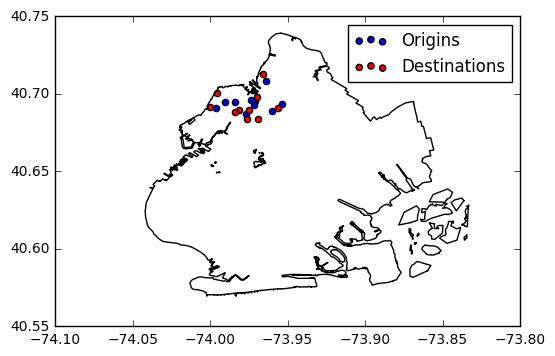

In [113]:
nyc_brooklyn_org = nyc_cbstations[nyc_cbstations.BoroName == 'Brooklyn'].sample(10, random_state = 100)
nyc_brooklyn_org.reset_index(inplace=True, drop=True)
nyc_brooklyn_des = nyc_cbstations[nyc_cbstations.BoroName == 'Brooklyn'].sample(10, random_state = 25)
nyc_brooklyn_des.reset_index(inplace=True, drop=True)

fig = plt.figure()
ax = fig.gca()
boro[boro.BoroName == 'Brooklyn'].plot(ax = ax, alpha = 0)
plt.scatter(nyc_brooklyn_org['long'],nyc_brooklyn_org.lat, c = 'blue', label = 'Origins')
plt.scatter(nyc_brooklyn_des['long'],nyc_brooklyn_des.lat, c = 'red', label = 'Destinations')
plt.legend(loc='best')

In [114]:
origins = parameters(nyc_brooklyn_org) 
destns = parameters(nyc_brooklyn_des) 

# Bicycling

In [130]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + origins + "&destinations=" + destns + "&mode=bicycling&key="+key)

In [116]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [118]:
routes_bike_brk =  create_frame(org=nyc_brooklyn_org, dest=nyc_brooklyn_des, info=info, mode='bicycling', time = None)

In [121]:
routes_bike_brk.head(2)

,org_id,org_lat,org_long,org_name,des_id,des_lat,des_long,des_name,dist_bike_mi,dur_bike_mins
0,274.0,40.686919,-73.976682,"38 Lafayette Ave, Brooklyn, NY 11217, USA",398.0,40.691652,-73.999979,"50 Columbia St, Brooklyn, NY 11201, USA",2.1,13.0
1,274.0,40.686919,-73.976682,"38 Lafayette Ave, Brooklyn, NY 11217, USA",241.0,40.689810,-73.974931,"146-150 Dekalb Ave, Brooklyn, NY 11217, USA",0.4,3.0


# Driving at 6pm

In [122]:
t = str(int(time.mktime(time.strptime('2017-05-29 18:00:00', '%Y-%m-%d %H:%M:%S'))))

In [123]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + origins + "&destinations=" +destns + "&mode=driving&departure_time=" + t + "&key="+key)

In [124]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [126]:
routes_drive_6pm_bk =  create_frame(org=nyc_brooklyn_org, dest=nyc_brooklyn_des, info=info, mode='driving', time = '6pm')

In [137]:
routes_drive_6pm_bk.head()

,org_id,org_lat,org_long,org_name,des_id,des_lat,des_long,des_name,dist_drive_6pm_mi,dur_drive_6pm_mins
0,274.0,40.686919,-73.976682,"38 Lafayette Ave, Brooklyn, NY 11217, USA",398.0,40.691652,-73.999979,"13 Atlantic Ave, Brooklyn, NY 11201, USA",2.0,16.0
1,274.0,40.686919,-73.976682,"38 Lafayette Ave, Brooklyn, NY 11217, USA",241.0,40.689810,-73.974931,"146-150 Dekalb Ave, Brooklyn, NY 11217, USA",0.4,3.0
2,274.0,40.686919,-73.976682,"38 Lafayette Ave, Brooklyn, NY 11217, USA",397.0,40.684157,-73.969223,"847-871 Fulton St, Brooklyn, NY 11238, USA",0.4,3.0
3,274.0,40.686919,-73.976682,"38 Lafayette Ave, Brooklyn, NY 11217, USA",83.0,40.683826,-73.976323,"608 Atlantic Ave, Brooklyn, NY 11217, USA",0.3,4.0
4,274.0,40.686919,-73.976682,"38 Lafayette Ave, Brooklyn, NY 11217, USA",460.0,40.712859,-73.965903,"52 S 4th St, Brooklyn, NY 11249, USA",3.1,18.0


# Driving at 9am

In [132]:
t = str(int(time.mktime(time.strptime('2017-05-29 09:00:00', '%Y-%m-%d %H:%M:%S'))))

In [133]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + origins + "&destinations=" +destns + "&mode=driving&departure_time=" + t + "&key="+key)

In [134]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [135]:
routes_drive_9am_bk =  create_frame(org=nyc_brooklyn_org, dest=nyc_brooklyn_des, info=info, mode='driving', time = '9am')

# Driving at 2pm

In [138]:
t = str(int(time.mktime(time.strptime('2017-05-29 14:00:00', '%Y-%m-%d %H:%M:%S'))))

In [139]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + origins + "&destinations=" +destns + "&mode=driving&departure_time=" + t + "&key="+key)

In [140]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [141]:
routes_drive_2pm_bk =  create_frame(org=nyc_brooklyn_org, dest=nyc_brooklyn_des, info=info, mode='driving', time = '2pm')

# Driving at 2pm on Saturday

In [143]:
t = str(int(time.mktime(time.strptime('2017-06-03 14:00:00', '%Y-%m-%d %H:%M:%S'))))

In [144]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + origins + "&destinations=" +destns + "&mode=driving&departure_time=" + t + "&key="+key)

In [145]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [146]:
routes_drive_2pm_sat_bk = create_frame(org=nyc_brooklyn_org, dest=nyc_brooklyn_des, info=info, mode='driving', time = '2pm_sat')

# Transit at 6pm

In [147]:
t = str(int(time.mktime(time.strptime('2017-05-29 18:00:00', '%Y-%m-%d %H:%M:%S'))))

In [148]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + origins + "&destinations=" +destns + "&mode=transit&departure_time=" + t + "&key="+key)

In [149]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [150]:
routes_transit_6pm_bk = create_frame(org=nyc_brooklyn_org, dest=nyc_brooklyn_des, info=info, mode='transit', time='6pm')

# Transit at 9am

In [151]:
t = str(int(time.mktime(time.strptime('2017-05-29 09:00:00', '%Y-%m-%d %H:%M:%S'))))

In [152]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + origins + "&destinations=" +destns + "&mode=transit&departure_time=" + t + "&key="+key)

In [153]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [154]:
routes_transit_9am_bk = create_frame(org=nyc_brooklyn_org, dest=nyc_brooklyn_des, info=info, mode='transit', time='9am')

# Transit at 2pm

In [196]:
t = str(int(time.mktime(time.strptime('2017-05-29 14:00:00', '%Y-%m-%d %H:%M:%S'))))

In [197]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + origins + "&destinations=" +destns + "&mode=transit&departure_time=" + t + "&key="+key)

In [198]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [199]:
routes_transit_2pm_bk = create_frame(org=nyc_brooklyn_org, dest=nyc_brooklyn_des, info=info, mode='transit', time='2pm')

# Transit at 2pm on Saturday

In [200]:
t = str(int(time.mktime(time.strptime('2017-06-03 14:00:00', '%Y-%m-%d %H:%M:%S'))))

In [201]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + origins + "&destinations=" +destns + "&mode=transit&departure_time=" + t + "&key="+key)

In [202]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [203]:
routes_transit_2pm_sat_bk = create_frame(org=nyc_brooklyn_org, dest=nyc_brooklyn_des, info=info, mode='transit', time='2pm_sat')

# Aggregate Brooklyn

In [204]:
routes_bk = merge_routes(dfs = [routes_bike_brk, routes_drive_2pm_bk, routes_drive_2pm_sat_bk, routes_drive_6pm_bk, 
                                routes_drive_9am_bk, routes_transit_2pm_bk, routes_transit_2pm_sat_bk, routes_transit_6pm_bk, 
                                routes_transit_9am_bk])

In [207]:
os.system("mkdir ../../Data/Routes")
routes_bk.to_csv("../../Data/Routes/routes_brooklyn.csv")

# Queens

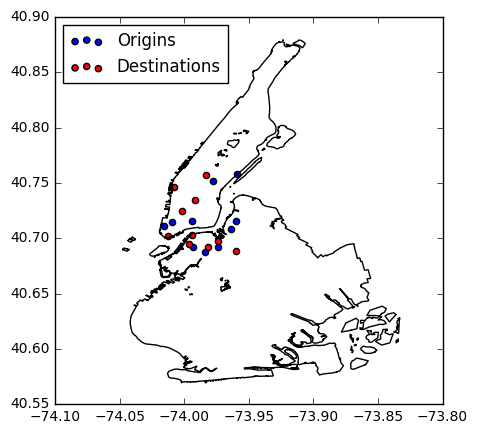

In [269]:
nyc_org1 = nyc_cbstations[nyc_cbstations.BoroName == 'Manhattan'].sample(5, random_state = 155)
nyc_org2 = nyc_cbstations[nyc_cbstations.BoroName == 'Brooklyn'].sample(5, random_state = 120)
nyc_org = pd.concat([nyc_org1, nyc_org2], ignore_index=True)

nyc_des1 = nyc_cbstations[nyc_cbstations.BoroName == 'Manhattan'].sample(5, random_state = 11110)
nyc_des2 = nyc_cbstations[nyc_cbstations.BoroName == 'Brooklyn'].sample(5, random_state = 12)
nyc_des = pd.concat([nyc_des1, nyc_des2], ignore_index=True)

fig = plt.figure(figsize=(5,5))
ax = fig.gca()
boro[(boro.BoroName == 'Manhattan') | (boro.BoroName == 'Brooklyn')].plot(ax = ax, alpha = 0)
plt.scatter(nyc_org['long'],nyc_org.lat, c = 'blue', label = 'Origins')
plt.scatter(nyc_des['long'],nyc_des.lat, c = 'red', label = 'Destinations')
plt.legend(loc='best')

In [270]:
org_nyc = parameters(nyc_org) 
des_nyc = parameters(nyc_des)

# Bicycling

In [274]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org_nyc + "&destinations=" + des_nyc + "&mode=bicycling&key="+key)

In [275]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [276]:
routes_bike_nyc =  create_frame(org=nyc_org, dest=nyc_des, info=info, mode='bicycling', time = None)

# Driving at 6pm

In [278]:
t = str(int(time.mktime(time.strptime('2017-05-31 18:00:00', '%Y-%m-%d %H:%M:%S'))))

In [279]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org_nyc + "&destinations=" +des_nyc + "&mode=driving&departure_time=" + t + "&key="+key)

In [280]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [281]:
routes_drive_6pm_nyc =  create_frame(org=nyc_org, dest=nyc_des, info=info, mode='driving', time = '6pm')

# Driving at 9am

In [287]:
t = str(int(time.mktime(time.strptime('2017-06-01 09:00:00', '%Y-%m-%d %H:%M:%S'))))

In [288]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org_nyc + "&destinations=" +des_nyc + "&mode=driving&departure_time=" + t + "&key="+key)

In [289]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [290]:
routes_drive_9am_nyc =  create_frame(org=nyc_org, dest=nyc_des, info=info, mode='driving', time = '9am')

# Driving at 2pm

In [291]:
t = str(int(time.mktime(time.strptime('2017-06-01 14:00:00', '%Y-%m-%d %H:%M:%S'))))

In [292]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org_nyc + "&destinations=" +des_nyc + "&mode=driving&departure_time=" + t + "&key="+key)

In [293]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [295]:
routes_drive_2pm_nyc =  create_frame(org=nyc_org, dest=nyc_des, info=info, mode='driving', time = '2pm')

# Driving at 2pm on Saturday

In [296]:
t = str(int(time.mktime(time.strptime('2017-06-03 14:00:00', '%Y-%m-%d %H:%M:%S'))))

In [297]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org_nyc + "&destinations=" +des_nyc + "&mode=driving&departure_time=" + t + "&key="+key)

In [298]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [299]:
routes_drive_2pm_sat_nyc = create_frame(org=nyc_org, dest=nyc_des, info=info, mode='driving', time = '2pm_sat')

# Transit at 6pm

In [300]:
t = str(int(time.mktime(time.strptime('2017-05-31 18:00:00', '%Y-%m-%d %H:%M:%S'))))

In [301]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org_nyc + "&destinations=" +des_nyc + "&mode=transit&departure_time=" + t + "&key="+key)

In [302]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [303]:
routes_transit_6pm_nyc = create_frame(org=nyc_org, dest=nyc_des, info=info, mode='transit', time='6pm')

# Transit at 9am

In [304]:
t = str(int(time.mktime(time.strptime('2017-06-01 09:00:00', '%Y-%m-%d %H:%M:%S'))))

In [305]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org_nyc + "&destinations=" +des_nyc + "&mode=transit&departure_time=" + t + "&key="+key)

In [306]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [307]:
routes_transit_9am_nyc = create_frame(org=nyc_org, dest=nyc_des, info=info, mode='transit', time='9am')

# Transit at 2pm

In [309]:
t = str(int(time.mktime(time.strptime('2017-06-01 14:00:00', '%Y-%m-%d %H:%M:%S'))))

In [310]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org_nyc + "&destinations=" +des_nyc + "&mode=transit&departure_time=" + t + "&key="+key)

In [311]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [313]:
routes_transit_2pm_nyc = create_frame(org=nyc_org, dest=nyc_des, info=info, mode='transit', time='2pm')

# Transit at 2pm on Saturday

In [314]:
t = str(int(time.mktime(time.strptime('2017-06-03 14:00:00', '%Y-%m-%d %H:%M:%S'))))

In [315]:
url =("https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&\
origins=" + org_nyc + "&destinations=" +des_nyc + "&mode=transit&departure_time=" + t + "&key="+key)

In [316]:
response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
info = json.loads(data)

In [317]:
routes_transit_2pm_sat_nyc = create_frame(org=nyc_org, dest=nyc_des, info=info, mode='transit', time='2pm_sat')

# Aggregate NYC

In [320]:
routes_nyc = merge_routes(dfs = [routes_bike_nyc, routes_drive_2pm_nyc, routes_drive_2pm_sat_nyc, routes_drive_6pm_nyc, 
                                routes_drive_9am_nyc, routes_transit_2pm_nyc, routes_transit_2pm_sat_nyc, routes_transit_6pm_nyc, 
                                routes_transit_9am_nyc])

In [321]:
os.system("mkdir ../../Data/Routes")
routes_nyc.to_csv("../../Data/Routes/routes_nyc.csv")